In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(["EIN", 'NAME'],axis=1)

# Attempt 3: Remove ORGANIZATION to see if it's too noisy
# application_df = application_df.drop(['ORGANIZATION'],axis=1)

# Attempt 4: INCOME_AMT has a local maximum
application_df = application_df.drop(['INCOME_AMT'],axis=1)

In [3]:
# Look at APPLICATION_TYPE value counts for binning
density = application_df.APPLICATION_TYPE.value_counts()

In [4]:
# Determine which values to replace if counts are less than ...?
replace_application = list(density[density < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [5]:
# Look at CLASSIFICATION value counts for binning
class_density = application_df.CLASSIFICATION.value_counts()
class_density

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C2500        1
C1900        1
C1236        1
C2570        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [6]:
# Determine which values to replace if counts are less than ..?
replace_class = list(class_density[class_density < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [7]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == 'object'].index.tolist()

In [8]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [9]:
# Merge one-hot encoded features and drop the originals
merged_df = application_df.merge(encode_df,left_index=True,right_index=True).drop(application_cat,axis=1)
merged_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [10]:
# Split our preprocessed data into our features and target arrays
X = merged_df.drop('IS_SUCCESSFUL', axis=1)
y = merged_df['IS_SUCCESSFUL'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
# Attempt 1: logistic regression instead of deep learning
# Import additional dependencies
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Define logistic regression model
log_classifier = LogisticRegression(solver='lbfgs',max_iter=200)

# Train model
log_classifier.fit(X_train,y_train)

# Evaluate model
y_pred = log_classifier.predict(X_test)
print(f" Logistic regression model accuracy: {accuracy_score(y_test, y_pred):.3f}")
# Logistic regression model accuracy: 0.471 < 75%
# Logistic regression remains 0.471 with ORGANIZATION removed
# Logistic regression remains 0.471 with INCOME_AMT removed

 Logistic regression model accuracy: 0.471


In [30]:
# Attempt 2: Adding third hidden layer
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import math

inputs = len(X.columns)
nodes1 = inputs*3
nodes2 = int(math.sqrt(nodes1)+1)
nodes3 = int(math.sqrt(nodes2)+1)

nn3 = tf.keras.models.Sequential()

# First hidden layer
nn3.add(Dense(units=nodes1, input_dim=inputs, activation="relu"))

# Second hidden layer
nn3.add(tf.keras.layers.Dense(units=nodes2, activation='relu'))

# Third hidden layer
nn3.add(tf.keras.layers.Dense(units=nodes3, activation='relu'))

# Output layer
nn3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
       
# Check model structure
nn3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 102)               3570      
_________________________________________________________________
dense_11 (Dense)             (None, 11)                1133      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 48        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 4,756
Trainable params: 4,756
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Attempt 5 - Increase nodes in second hidden layer
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

inputs = len(X.columns)
nodes1 = inputs*3
nodes2 = 15

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(Dense(units=nodes1, input_dim=inputs, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes2, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
       
# Check model structure
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 102)               3570      
_________________________________________________________________
dense_8 (Dense)              (None, 15)                1545      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 5,131
Trainable params: 5,131
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# Create callback that saves model weight every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4000)

In [33]:
# Train the model
fit_model = nn.fit(X_train, y_train,epochs=100,callbacks=[cp_callback])
# ATTEMPT 2: Epoch 00100: saving model to checkpoints\weights.100.hdf5
# 804/804 [==============================] - 1s 672us/step - loss: 0.6909 - accuracy: 0.5339 < 75%
# ATTEMPT 3: Epoch 00100: saving model to checkpoints\weights.100.hdf5
# 804/804 [==============================] - 1s 685us/step - loss: 0.6915 - accuracy: 0.5293 < 75%
# ATTEMPT 4: Epoch 00100: saving model to checkpoints\weights.100.hdf5
# 804/804 [==============================] - 1s 976us/step - loss: 0.6910 - accuracy: 0.5328 < 75%
# ATTEMPT 5: Epoch 00100: saving model to checkpoints\weights.100.hdf5
# 804/804 [==============================] - 1s 700us/step - loss: 0.6909 - accuracy: 0.5335 < 75%

Epoch 1/100
804/804 [==============================] - 1s 679us/step - loss: 0.7106 - accuracy: 0.5326
Epoch 2/100
804/804 [==============================] - 1s 634us/step - loss: 0.6905 - accuracy: 0.5377
Epoch 3/100
804/804 [==============================] - 1s 637us/step - loss: 0.6916 - accuracy: 0.52860s - loss: 0.6916 - accuracy: 0.52
Epoch 4/100
804/804 [==============================] - 1s 655us/step - loss: 0.6913 - accuracy: 0.5314
Epoch 5/100
376/804 [=============>................] - ETA: 0s - loss: 0.6907 - accuracy: 0.5361
Epoch 00005: saving model to checkpoints\weights.05.hdf5
804/804 [==============================] - 1s 705us/step - loss: 0.6909 - accuracy: 0.5348
Epoch 6/100
804/804 [==============================] - 1s 676us/step - loss: 0.6911 - accuracy: 0.5333
Epoch 7/100
804/804 [==============================] - 1s 654us/step - loss: 0.6914 - accuracy: 0.5309
Epoch 8/100
804/804 [==============================] - 1s 651us/step - loss: 0.6903 - accuracy: 0.5398


804/804 [==============================] - 1s 660us/step - loss: 0.6908 - accuracy: 0.5350
Epoch 63/100
804/804 [==============================] - 1s 657us/step - loss: 0.6906 - accuracy: 0.5382
Epoch 64/100
804/804 [==============================] - 1s 631us/step - loss: 0.6914 - accuracy: 0.5306
Epoch 65/100
 79/804 [=>............................] - ETA: 0s - loss: 0.6911 - accuracy: 0.5325
Epoch 00065: saving model to checkpoints\weights.65.hdf5
804/804 [==============================] - 1s 685us/step - loss: 0.6907 - accuracy: 0.5357
Epoch 66/100
804/804 [==============================] - 1s 634us/step - loss: 0.6913 - accuracy: 0.5319
Epoch 67/100
804/804 [==============================] - 1s 665us/step - loss: 0.6900 - accuracy: 0.5401
Epoch 68/100
804/804 [==============================] - 1s 654us/step - loss: 0.6916 - accuracy: 0.5281
Epoch 69/100
804/804 [==============================] - 1s 700us/step - loss: 0.6913 - accuracy: 0.5324
Epoch 70/100
 68/804 [=>...............

<AxesSubplot:ylabel='Density'>

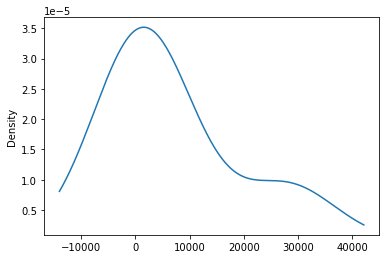

In [26]:
# Attempt 3: Check data for noise/outliers
noise_search = application_df.USE_CASE.value_counts()
noise_search.plot.density()

<AxesSubplot:ylabel='Density'>

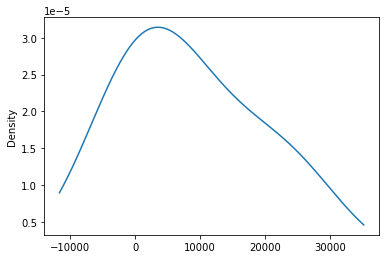

In [27]:
noise_search = application_df.ORGANIZATION.value_counts()
noise_search.plot.density()
# Fat tail for organization. See results with organization removed.

In [28]:
noise_search = application_df.INCOME_AMT.value_counts()
noise_search.plot.density()

AttributeError: 'DataFrame' object has no attribute 'INCOME_AMT'

<AxesSubplot:ylabel='Density'>

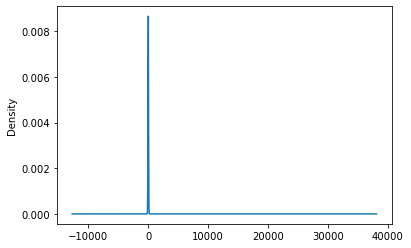

In [29]:
noise_search = application_df.ASK_AMT.value_counts()
noise_search.plot.density()

In [ ]:
noise_search = application_df.SPECIAL_CONSIDERATIONS.value_counts()
noise_search.plot.density()

In [21]:
# Attempt 6 - Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Create rf classifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fit model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.706


In [ ]:
# Export 'optimized' model to HDF5 file
nn3.save("AlphabetSoupCharity_Optimization.h5")